COMP4423 – Computer Vision

Group Project: Fashion Image Generation

Group 1

JIANG Yiyang (21095707d)  
YE Haowen (21098829d)  
ZHANG Wengyu (21098431d)  

April 2023

---

### This is the **ACGAN model training and validation program** for the Project

### This ACGAN model is chosen as the final model for the project for its relatively good performance.

<font color='red' size='5'> Please carefully read User_Manual.pdf file first before running </font>

Auxiliary Classifier GAN (ACGAN)  
Reference: 
- https://github.com/Hydrino/ACGAN_cifar10
- https://github.com/pytorch/examples/tree/main/dcgan
- https://github.com/soumith/dcgan.torch
- https://doi.org/10.48550/arXiv.1511.06434 [DCGAN paper PDF]

In [1]:
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
from datetime import datetime
import copy
import seaborn as sns
import cv2

torch.__version__

torch.manual_seed(42)

trainPath = './fashion-mnist/train.csv' # Path of data
testPath = './fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0002

# Set proper device according to your machine!
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('mps') # use 'mps' if your Mac has Apple Silicon MPS GPU acceleration
print(device)

mps


In [2]:
# define a class for data
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label

def loadImage(inPath):
    samples = []
    dataCsv = pd.read_csv(inPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values.astype('uint8')
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

trainSamples, trainImages, trainLabels = loadImage(trainPath)
testSamples, testImages, testLabels = loadImage(testPath)

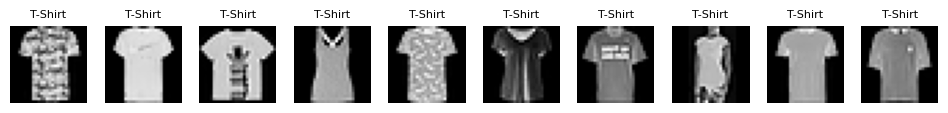

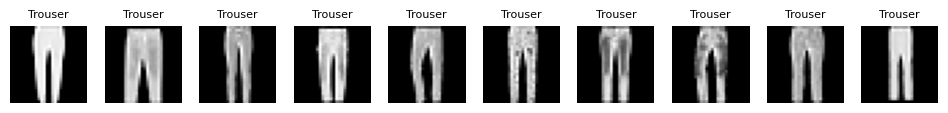

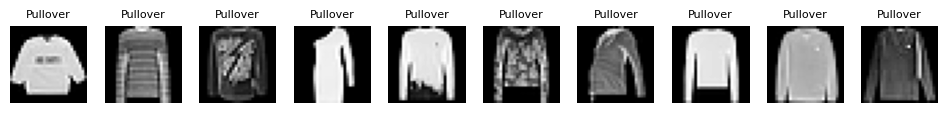

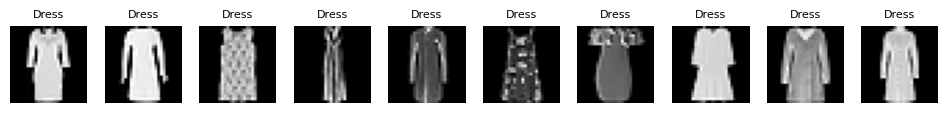

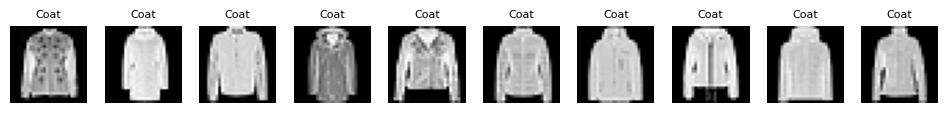

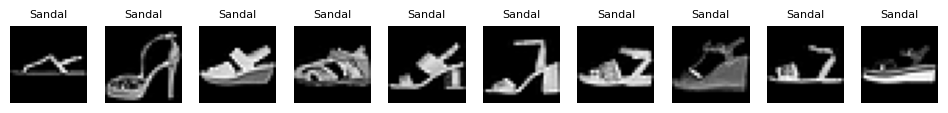

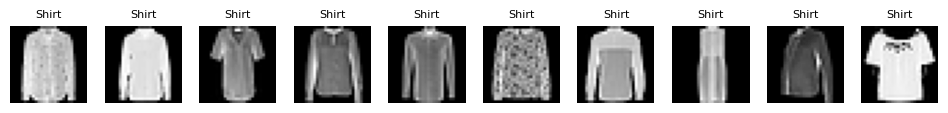

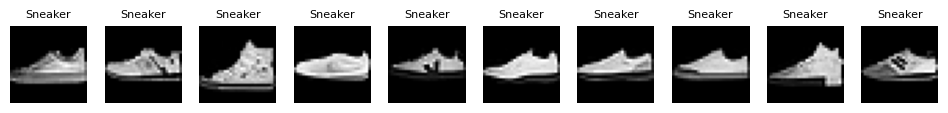

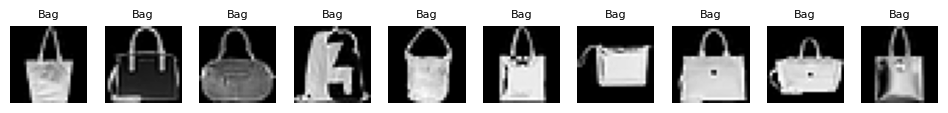

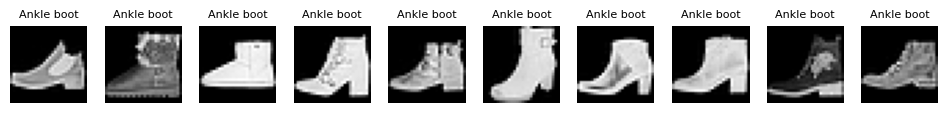

In [3]:
# Task 1: Preprocess the fashion image dataset and visualize some example images.
imgList = []
for l in range(10):
    count = 0
    for sample in trainSamples:
        if int(sample.label) == l:
            if count%10 == 0:
                plt.figure(figsize=(12, 1))
            plt.subplot(1, 10, count%10+1)
            plt.title(labelMap[int(l)], fontsize=8)
            plt.axis('off')
            plt.imshow(sample.img, cmap ='gray')
            count += 1
            if (count >= 10):
                break


In [4]:
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

# Training and testing data loader

train = FashionDataset(trainImages, trainLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = FashionDataset(testImages, testLabels, transform = transform)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [5]:
# Define the model
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        self.label_embed = nn.Embedding(10,100)
        
        self.model = nn.Sequential(
            # 100 1 1
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 512 4 4
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 256 8 8
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 128 16 16
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # 64 32 32
            nn.ConvTranspose2d(64,1,4,2,1,bias = False),
            nn.Flatten(),
            # 1 64 64
            nn.Linear(1*64*64, 1*28*28),
            # 1 28 28
            nn.Tanh()
        )
    
    def forward(self,X,label):
        label = self.label_embed(label)
        x = torch.mul(X,label)
        x = x.view(-1,100,1,1)
        x = self.model(x)
        return x.view(-1,1,28,28)
        

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        self.model = nn.Sequential(
            # 1 28 28
            nn.Conv2d(1,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Dropout2d(0.5),
            
            # 64 14 14
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Dropout2d(0.5) 
            # 128 7 7
        )
        
        self.D_layer = nn.Sequential(
            nn.Conv2d(128,1,7,1,0,bias = False), 
            # 128 7 7 -> 1                                   
            nn.Sigmoid())
        
        self.class_layer = nn.Sequential(
            nn.Conv2d(128,11,7,1,0,bias = False), # 11th label: 'fake'
            # 128 7 7 -> 11
            nn.LogSoftmax(dim = 1))
        
    def forward(self,X):
        x = self.model(X)        
        dis = self.D_layer(x).view(-1)
        cla = self.class_layer(x).view(-1,11)
        return dis,cla

In [6]:
# referenced from https://github.com/soumith/dcgan.torch, sample code of the DCGAN paper
def inWeights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

G = Generator()
G.to(device)
G.apply(inWeights)

D = Discriminator()
D.to(device)
D.apply(inWeights)
        
optimG = optim.Adam(G.parameters(), lr = learning_rate, betas = (0.5,0.999))
optimD = optim.Adam(D.parameters(), lr = learning_rate, betas = (0.5,0.999))

criterion = nn.BCEWithLogitsLoss()
labelCriterion = nn.NLLLoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)


EPOCH 002 finalized: discriminator loss 0.003320 - gererator loss 0.002420, time 184.915670s


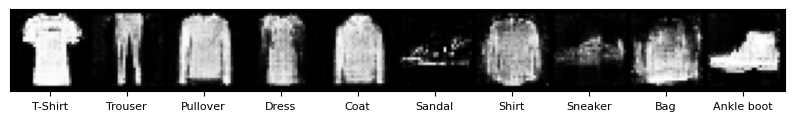

EPOCH 004 finalized: discriminator loss 0.003455 - gererator loss 0.002480, time 369.137584s


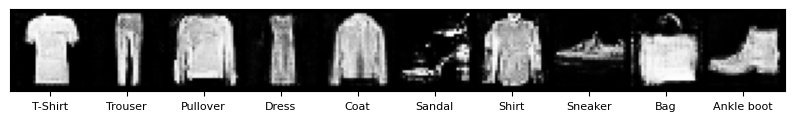

EPOCH 006 finalized: discriminator loss 0.003152 - gererator loss 0.002188, time 553.277534s


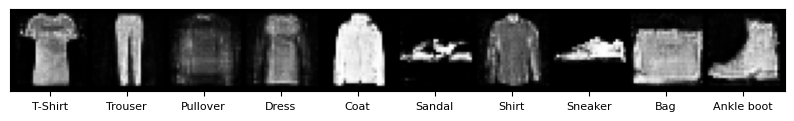

EPOCH 008 finalized: discriminator loss 0.003445 - gererator loss 0.001939, time 737.528090s


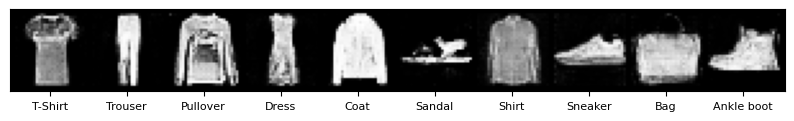

EPOCH 010 finalized: discriminator loss 0.003465 - gererator loss 0.002010, time 922.184597s


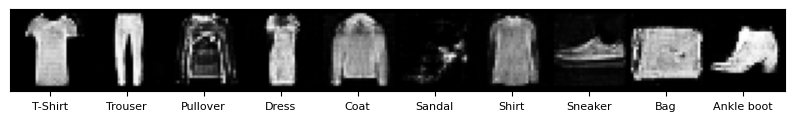

Model saved to ACGAN6_G_10_1.pth


In [7]:
# training

EPOCHS = 30
gLoss = dict()
dLoss = dict()
startTime = datetime.now()
for epoch in range(0,EPOCHS):
    D_running_loss = 0
    G_running_loss = 0
    
    for idx, (realImages,realLabels) in enumerate(train_loader,0):
        
        batch_size = realImages.size(0)
        realLabels= realLabels.to(device)
        realImages = realImages.to(device)
        
        # realLabelValue = real_labels[idx % 10]
        # fakeLabelValue = fake_labels[idx % 10]
        realLabelValue = 1.0
        fakeLabelValue = 0.0
           
        # ########## train the Discriminator ##########
        
        optimD.zero_grad()       
        
        # 1. train on real image
        dRealFake, dLabel = D(realImages)       
        
        defaultReal = torch.full((batch_size,),realLabelValue, device = device)
        dLossReal = criterion(dRealFake, defaultReal)            
        dLossRealClass = labelCriterion(dLabel,realLabels)
        
        dLossRealTotal = dLossReal + dLossRealClass
        dLossRealTotal.backward()
                
        # 2. train on fake image
        
        # generate fake image
        random = torch.randn(batch_size,100,device = device)  
        randomLabels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        fakeImages = G(random,randomLabels)
        
        defaultFake = torch.full((batch_size,),fakeLabelValue, device = device)
        fakeLabels = 10*torch.ones((batch_size,),dtype = torch.long,device = device) # all set as 'fake' label
        
        dRealFake, dLabel = D(fakeImages.detach())       
        
        dLossFake = criterion(dRealFake, defaultFake)
        dLossFakeClass = labelCriterion(dLabel, fakeLabels)
        
        dLossFakeTotal = dLossFake + dLossFakeClass
        dLossFakeTotal.backward()
        
        dLossTotal = dLossRealTotal + dLossFakeTotal
        
        optimD.step()
    
        
        # ########## train the Generator ##########
        
        optimG.zero_grad()
        
        random = torch.randn(batch_size,100,device = device)  
        randomLabels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        defaultReal = torch.full((batch_size,), 1.0, device = device)
        
        # generate fake image
        fakeImages = G(random,randomLabels)
        dRealFake,dLabel = D(fakeImages)
        
        gLossFake = criterion(dRealFake, defaultReal)        
        gLossFakeClass = labelCriterion(dLabel, randomLabels)
        
        gLossTotal = gLossFake + gLossFakeClass
        gLossTotal.backward()
        
        optimG.step()
        
        D_running_loss += dLossTotal.item()
        G_running_loss += gLossTotal.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
  
    if (epoch + 1) % 2 == 0:
        endTime = datetime.now()
        duration = (endTime - startTime).total_seconds()
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}, time {:03.6f}s'.format(epoch + 1, D_running_loss, G_running_loss, duration))
        
        # display 10 generated images
        random = torch.randn(10, 100).to(device)
        random_labels = np.array([i for _ in range(1) for i in range(10)])
        random_labels = torch.from_numpy(random_labels).int().to(device)
        output  = G.forward(random, random_labels).unsqueeze(1).data
        output = output.view(10, 1, 28, 28)
        grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(grid)
        plt.yticks([])
        plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)
        plt.show()

savePath = 'ACGAN6_G_30_1.pth'
torch.save(G, savePath)
print('Model saved to {}'.format(savePath))

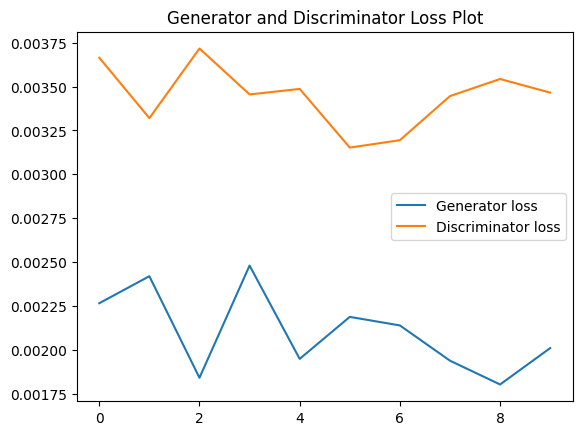

In [8]:
# Visualize the loss plot
plt.title("Generator and Discriminator Loss Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
plt.legend()
plt.show()

ACGAN6_G_30_1.pth


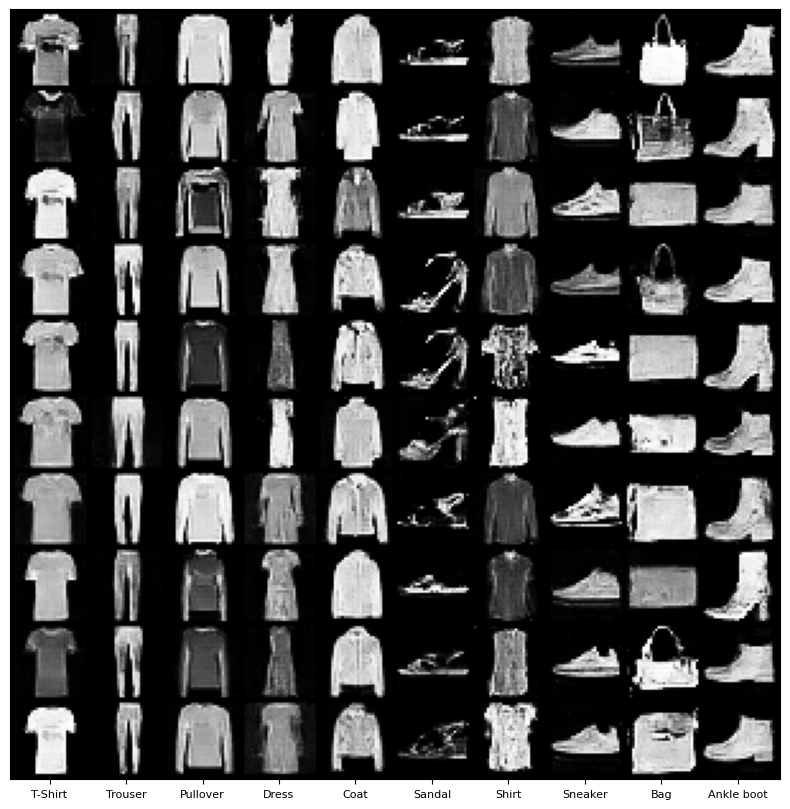

In [7]:
# Test on the trained model
savePath = 'ACGAN6_G_30_1.pth'

loadPath = savePath
print(loadPath)

device = torch.device('cpu')

G = torch.load(loadPath, map_location=device)

random = torch.randn(100, 100).to(device)

random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).detach().unsqueeze(1).data

output = output.view(100, 1, 28, 28)

grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
plt.yticks([])
plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)
plt.show()

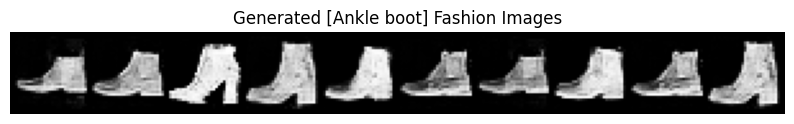

In [9]:
# generate N images from a label
def generateFromLabel(inG, inLabel, inNum):
    random = torch.randn(inNum, 100).to(device)
    random_labels = np.array([i for _ in range(1) for i in [inLabel]*inNum])
    random_labels = torch.from_numpy(random_labels).int().to(device)
    output  = inG.forward(random, random_labels).unsqueeze(1).data.to(device)
    output = output.view(inNum, 1, 28, 28)
    grid = make_grid(output, nrow=inNum, normalize=True).permute(1,2,0).cpu().numpy()
    return grid

l = 9
n = 10
fig, ax = plt.subplots(figsize=(n,n))
img = generateFromLabel(G, l, n)
ax.imshow(img)
plt.title('Generated ['+labelMap[l]+'] Fashion Images')
plt.axis('off')
plt.show()

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_72990/4093209345.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, i+1)


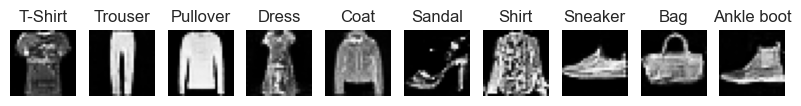

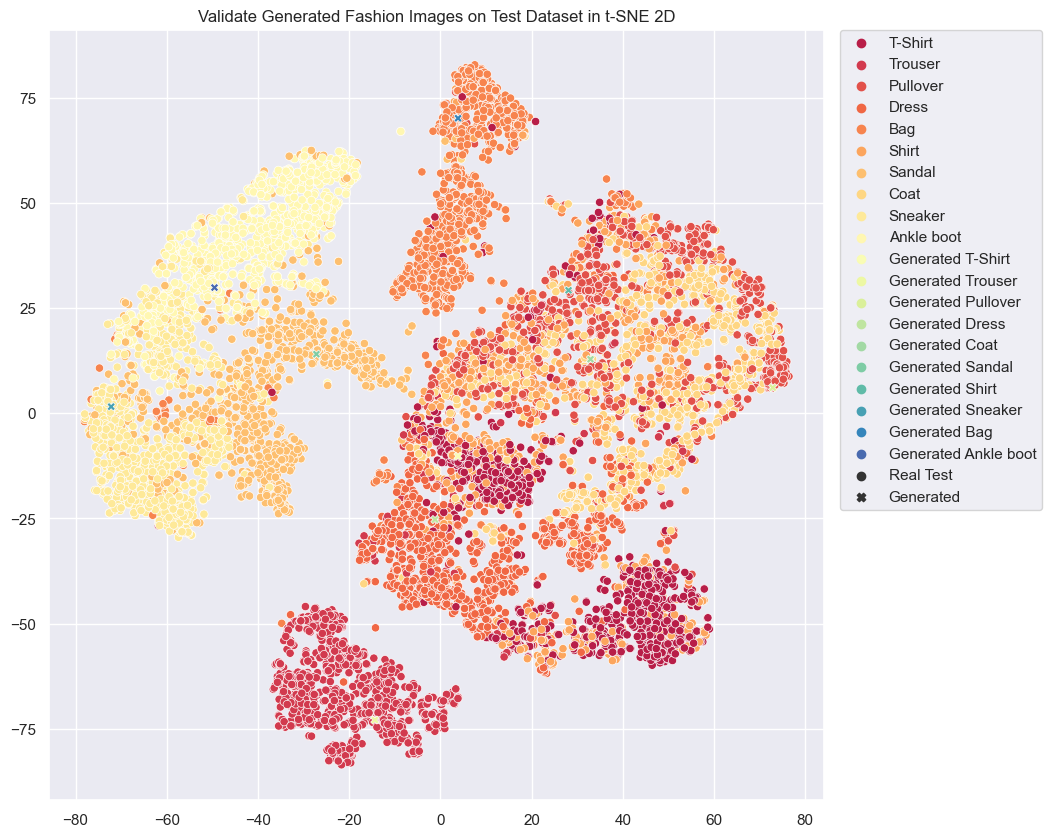

In [65]:
# Validate generated images on test dataset in t-SNE 2D
testlabelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 
                'Generated T-Shirt', 'Generated Trouser', 'Generated Pullover', 'Generated Dress', 'Generated Coat', 'Generated Sandal', 'Generated Shirt', 'Generated Sneaker', 'Generated Bag', 'Generated Ankle boot']

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("Spectral", 20) 

isTest = ['Real Test' for sample in testSamples]

test = testSamples
fig, ax = plt.subplots(figsize=(10,10))
for i in range(10):
    genImage = generateFromLabel(G, i, 1)
    genImage = cv2.normalize(src=genImage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    plt.subplot(1, 10, i+1)
    plt.title(labelMap[i])
    plt.axis('off')
    plt.imshow(genImage, cmap ='gray')
    
    genSample = Sample(img=genImage, feat = genImage[:,:,0].reshape(28*28), label=10+i)
    test = test+[genSample]
    isTest.append('Generated')
plt.axis('off')
plt.show()

featuresTest = np.array([sample.feat for sample in test])
labelsTest = [testlabelMap[sample.label] for sample in test]

tsne = TSNE()
XEmbeddedTest = tsne.fit_transform(featuresTest)
_ = sns.scatterplot(x=XEmbeddedTest[:,0], y=XEmbeddedTest[:,1], hue=labelsTest, style=isTest, legend='full', palette=palette).set(title='Validate Generated Fashion Images on Test Dataset in t-SNE 2D')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


<BarContainer object of 10 artists>

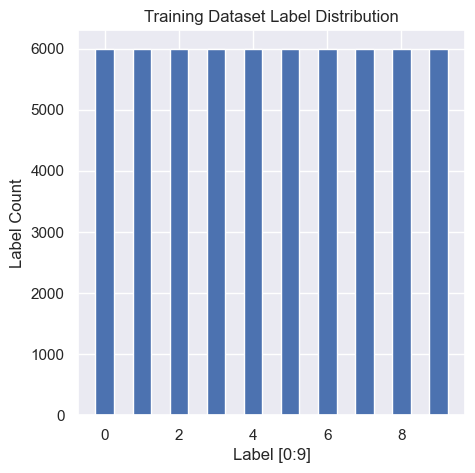

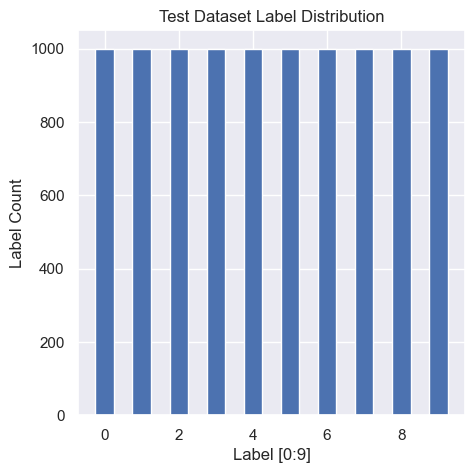

In [69]:
# Visualizations on Training Dataset and Test Dataset Label Distribution

labels = [sample.label for sample in trainSamples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(5, 5))
plt.title("Training Dataset Label Distribution")
plt.xlabel("Label [0:9]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

labels = [sample.label for sample in testSamples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(5, 5))
plt.title("Test Dataset Label Distribution")
plt.xlabel("Label [0:9]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

[Text(0.5, 1.0, 'Training Dataset Image Distribution t-SNE 2D')]

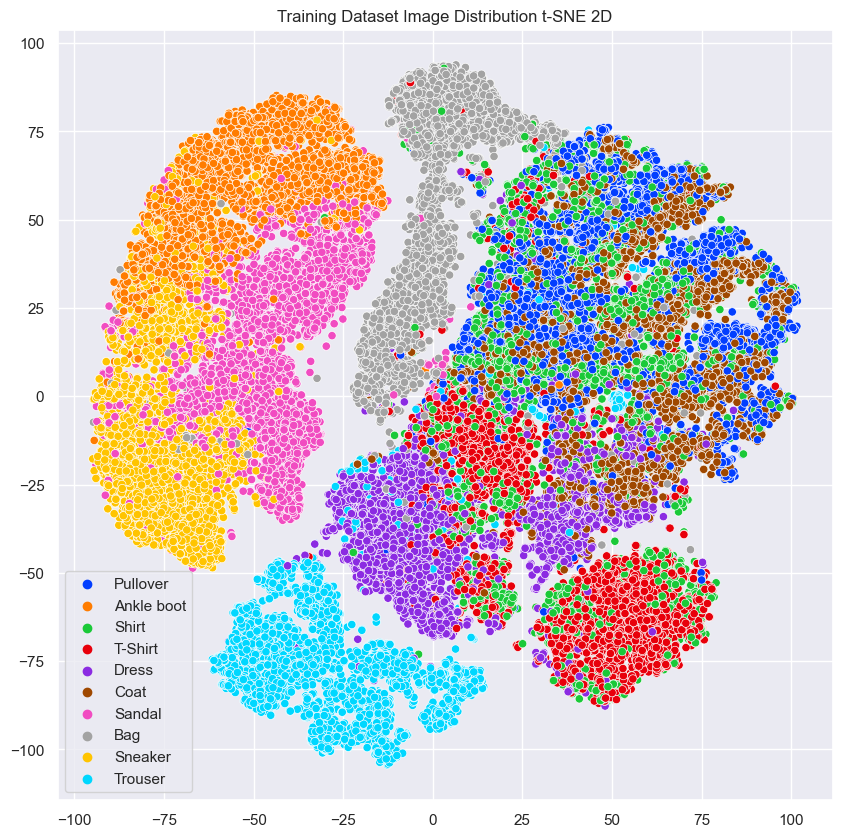

In [67]:
# Visualizations on training dataset pixel feature 2D distribution with t-NSE

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("bright", 10) 

featuresTrain = np.array([sample.feat for sample in trainSamples])
labelsTrain = [labelMap[sample.label] for sample in trainSamples]

tsne = TSNE() 
XEmbeddedTrain = tsne.fit_transform(featuresTrain)
sns.scatterplot(x=XEmbeddedTrain[:,0], y=XEmbeddedTrain[:,1], hue=labelsTrain, legend='full', palette=palette).set(title='Training Dataset Image Feature Distribution t-SNE 2D')
